## Prepare training data

In [1]:
import plotly.io as pio

# 确保默认渲染器支持嵌入
pio.renderers.default = "notebook_connected"

In [2]:
import torch
import numpy as np

# 定义参数
batch_size = 400
input_size = 1

# 定义随机性参数
sequence_lengths = [50, 100, 200, 500, 800]  # 可选的采样点数
period_range = (1, 100)  # 随机选择周期范围

# 初始化用于存储所有信号的列表dd
all_clean_batches = []
all_noisy_batches = []

# 生成多种随机信号并融合
for sequence_length in sequence_lengths:
    period = np.random.uniform(*period_range)  # 随机选择周期

    # 生成干净信号
    clean_signal = torch.sin(
        torch.linspace(0, 2 * np.pi * period, batch_size * sequence_length)
    ).unsqueeze(-1)   # 添加最后一维，使形状为 (batch_size * sequence_length, 1)
    clean_signal = (clean_signal - clean_signal.mean()) / clean_signal.std()

    # 划分为批次形式
    clean_batches = clean_signal.view(batch_size, sequence_length, input_size)

    # 生成噪声信号
    noise = torch.randn_like(clean_signal) * 0.2  # 调整噪声强度
    noisy_signal = clean_signal + noise
    noisy_signal = (noisy_signal - noisy_signal.mean()) / noisy_signal.std()
    noisy_batches = noisy_signal.view(batch_size, sequence_length, input_size)

    # 将生成的数据添加到列表中
    all_clean_batches.append((sequence_length, clean_batches))
    all_noisy_batches.append((sequence_length, noisy_batches))

# 确保序列长度相同的批次分别拼接
final_clean_batches = []
final_noisy_batches = []

for sequence_length in sequence_lengths:
    clean_batches_group = [cb for sl, cb in all_clean_batches if sl == sequence_length]
    noisy_batches_group = [nb for sl, nb in all_noisy_batches if sl == sequence_length]

    if clean_batches_group and noisy_batches_group:
        final_clean_batches.append(torch.cat(clean_batches_group, dim=0))
        final_noisy_batches.append(torch.cat(noisy_batches_group, dim=0))

# 打印拼接结果
for i, sequence_length in enumerate(sequence_lengths):
    if i < len(final_clean_batches):
        # length 5
        # torch.Size([400, 50, 1])
        print(f"Final clean batches for sequence length {sequence_length}: {final_clean_batches[i].size()}")
        print(f"Final noisy batches for sequence length {sequence_length}: {final_noisy_batches[i].size()}")

Final clean batches for sequence length 50: torch.Size([400, 50, 1])
Final noisy batches for sequence length 50: torch.Size([400, 50, 1])
Final clean batches for sequence length 100: torch.Size([400, 100, 1])
Final noisy batches for sequence length 100: torch.Size([400, 100, 1])
Final clean batches for sequence length 200: torch.Size([400, 200, 1])
Final noisy batches for sequence length 200: torch.Size([400, 200, 1])
Final clean batches for sequence length 500: torch.Size([400, 500, 1])
Final noisy batches for sequence length 500: torch.Size([400, 500, 1])
Final clean batches for sequence length 800: torch.Size([400, 800, 1])
Final noisy batches for sequence length 800: torch.Size([400, 800, 1])


## Create dataloader

In [3]:
from torch.utils.data import Dataset, DataLoader

# 定义自定义数据集
class TimeSeriesDataset(Dataset):
    def __init__(self, noisy_batches, clean_batches):
        self.noisy_batches = noisy_batches
        self.clean_batches = clean_batches

    def __len__(self):
        return len(self.noisy_batches)

    def __getitem__(self, idx):
        return self.noisy_batches[idx], self.clean_batches[idx]

### Train test and validation split

In [4]:
from torch.utils.data import Subset

# 按顺序划分数据集函数
def split_dataset_sequential(dataset, train_ratio=0.7, val_ratio=0.15):
    total_length = len(dataset)
    train_end = int(total_length * train_ratio)
    val_end = train_end + int(total_length * val_ratio)

    train_indices = list(range(0, train_end))
    val_indices = list(range(train_end, val_end))
    test_indices = list(range(val_end, total_length))

    train_dataset = Subset(dataset, train_indices)
    val_dataset = Subset(dataset, val_indices)
    test_dataset = Subset(dataset, test_indices)

    return train_dataset, val_dataset, test_dataset

# 划分数据集
train_dataloaders = []
val_dataloaders = []
test_dataloaders = []

for sequence_length, noisy_batch, clean_batch in zip(sequence_lengths,
                                                     final_noisy_batches,
                                                     final_clean_batches):
    dataset = TimeSeriesDataset(noisy_batch, clean_batch)

    train_dataset, val_dataset, test_dataset = split_dataset_sequential(dataset)

    # 确保加载时顺序不变
    train_dataloaders.append((sequence_length, DataLoader(train_dataset,
                                                          batch_size=60,
                                                          shuffle=False)))
    val_dataloaders.append((sequence_length, DataLoader(val_dataset,
                                                        batch_size=60,
                                                        shuffle=False)))
    test_dataloaders.append((sequence_length, DataLoader(test_dataset,
                                                         batch_size=60,
                                                         shuffle=False)))

print(f"Number of batches in dataloader: {len(train_dataloaders)}")
print(f"Number of batches in dataloader: {len(val_dataloaders)}")
print(f"Number of batches in dataloader: {len(test_dataloaders)}")


Number of batches in dataloader: 5
Number of batches in dataloader: 5
Number of batches in dataloader: 5


## Define model

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim

# 定义 LSTM 降噪模型
class LSTMDenoiser(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, input_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out)
        return out

# 初始化模型
model = LSTMDenoiser(input_size=1, hidden_size=128, num_layers=2)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# 加载模型
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Training on:", device)
model.to(device)

Training on: cuda


LSTMDenoiser(
  (lstm): LSTM(1, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

## Train model

In [6]:
import os

# 用于保存训练损失
learning_rates = []

num_epochs = 20  # 训练轮数

# 学习率调度器参数
# step_size=10：每 10 个 epoch 调整一次学习率。
# gamma=0.1：每次调整时学习率缩小为原来的 0.1 倍。
scheduler_step_size = 10
scheduler_gamma = 0.6

# 初始化变量以跟踪最佳模型
best_model_path = "models/best_model.pth"
last_model_path = "models/last_model.pth"


# 检查是否存在保存的模型检查点
if not os.path.exists("models"):
    os.makedirs("models")

# 检查是否存在之前的模型
if os.path.exists(best_model_path):
    print("Loading checkpoint...")
    checkpoint = torch.load(best_model_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    best_loss = checkpoint['loss']
    best_epoch = checkpoint['epoch'] + 1
    print(f"Resuming training from epoch {start_epoch} with best loss {best_loss:.8f}")
else:
    print("No checkpoint found, starting fresh training.")

# 初始化学习率调度器
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer, step_size=scheduler_step_size, gamma=scheduler_gamma
)

# 记录损失
train_losses = []
val_losses = []
best_val_loss = float('inf')

# Train model
model.train()

# 模型训练
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs} started.")
    epoch_loss = 0

    # 打印当前学习率
    for param_group in optimizer.param_groups:
        learning_rates.append(param_group['lr'])  # 将学习率加入列表
        print(f"Current learning rate: {param_group['lr']}")

    # 遍历每个 grouped_dataloader
    for sequence_length, dataloader in train_dataloaders:
        print(f"Training on sequence length {sequence_length}...")
        model.train()
        train_loss = 0  # 用于记录该组的损失

        for i, (noisy_batch, clean_batch) in enumerate(dataloader):
            # 将数据移动到 GPU（如果可用）
            noisy_batch = noisy_batch.to(device).float()
            clean_batch = clean_batch.to(device).float()

            # 前向传播
            outputs = model(noisy_batch)
            loss = criterion(outputs, clean_batch)

            # 反向传播和优化
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # 累加 batch 的损失
            train_loss += loss.item()

        # 打印每个组的平均损失
        train_losses.append(train_loss)

        # 验证模型
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for sequence_length, dataloader in val_dataloaders:
                for noisy_batch, clean_batch in dataloader:
                    noisy_batch = noisy_batch.to(device).float()
                    clean_batch = clean_batch.to(device).float()

                    outputs = model(noisy_batch)
                    loss = criterion(outputs, clean_batch)
                    val_loss += loss.item()

        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.8f}",
              f" Val Loss: {val_loss:.8f}")


    # 更新学习率
    scheduler.step()

    # 检查是否为最佳模型
    if val_loss < best_val_loss: 
        best_epoch=epoch+1
        best_loss = val_loss
        # torch.save(model.state_dict(), best_model_path)
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': best_loss,
            },
            best_model_path
        )
        print(f"New best model saved: {best_model_path} with loss: {best_loss:.8f}")

    # 保存当前 epoch 的模型
    # torch.save(model.state_dict(), last_model_path)
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': val_loss,
        },
        last_model_path
    )
    print(f"Last model saved at epoch {epoch+1}")

print(f"Training complete! Best model was from epoch {best_epoch} with loss: "
      f"{best_loss:.8f}")

No checkpoint found, starting fresh training.
Epoch 1/20 started.
Current learning rate: 0.001
Training on sequence length 50...
Epoch 1/20, Train Loss: 4.81441373  Val Loss: 4.30515438
Training on sequence length 100...
Epoch 1/20, Train Loss: 3.69937152  Val Loss: 2.19687450
Training on sequence length 200...
Epoch 1/20, Train Loss: 1.00875687  Val Loss: 1.08004507
Training on sequence length 500...
Epoch 1/20, Train Loss: 0.48681573  Val Loss: 0.33621852
Training on sequence length 800...
Epoch 1/20, Train Loss: 0.32188332  Val Loss: 0.46168970
New best model saved: models/best_model.pth with loss: 0.46168970
Last model saved at epoch 1
Epoch 2/20 started.
Current learning rate: 0.001
Training on sequence length 50...
Epoch 2/20, Train Loss: 0.61572033  Val Loss: 0.22219463
Training on sequence length 100...
Epoch 2/20, Train Loss: 0.28464403  Val Loss: 0.29561138
Training on sequence length 200...
Epoch 2/20, Train Loss: 0.18159439  Val Loss: 0.19028518
Training on sequence length 

## Plot results

In [7]:
import plotly.graph_objects as go

# 创建 Figure
fig = go.Figure()

# 添加损失曲线
fig.add_trace(go.Scatter(
    y=train_losses, 
    mode='lines+markers', 
    name='Training Loss',
    line=dict(color='blue'),
    marker=dict(size=5)
))

# 添加损失曲线
fig.add_trace(go.Scatter(
    y=val_losses, 
    mode='lines+markers', 
    name='Validation Loss',
    line=dict(color='orange'),
    marker=dict(size=5)
))

# 添加学习率曲线
fig.add_trace(go.Scatter(
    y=learning_rates, 
    mode='lines+markers', 
    name='Learning Rate',
    line=dict(color='red', dash='dash'),  # 使用虚线
    marker=dict(size=5)
))

# 更新布局
fig.update_layout(
    title='Training Loss and Learning Rate Curve',
    xaxis_title='Epoch',
    yaxis_title='Value',
    legend_title='Metrics',
    template='plotly'
)

# 显示图表
fig.show()

## Inference data

In [8]:
# 加载模型
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 假设你有一个定义好的模型类
model = LSTMDenoiser(input_size=1, hidden_size=128, num_layers=2)
model.to(device)

# 加载已训练的模型权重
checkpoint = torch.load("models/best_model.pth", map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()  # 设置模型为评估模式

# 预测降噪结果
with torch.no_grad():
    denoised_signal = model(final_noisy_batches[0][1].to(device))  # 添加 batch 维度 (1, sequence_length, input_size)
    denoised_signal = denoised_signal.squeeze(0)  # 移除 batch 维度，形状为 (sequence_length, input_size)

# 绘制降噪结果与干净信号的对比
fig3 = go.Figure()

# 绘制第一个 batch 的噪声信号、干净信号和去噪信号
fig3.add_trace(go.Scatter(y=final_noisy_batches[0][1].squeeze().cpu().numpy(), mode='lines', name='Noisy Signal'))  # 噪声信号
fig3.add_trace(go.Scatter(y=final_clean_batches[0][1].squeeze().cpu().numpy(), mode='lines', name='Clean Signal'))  # 干净信号
fig3.add_trace(go.Scatter(y=denoised_signal.squeeze().cpu().numpy(), mode='lines', name='Denoised Signal'))  # 去噪信号

fig3.update_layout(
    title='Denoised vs Clean Signal',
    xaxis_title='Time Step',
    yaxis_title='Signal Value',
    legend_title='Signal Type'
)

fig3.show()

In [9]:
import numpy as np
import torch
import plotly.graph_objects as go

# 模拟信号
sequence_length = 1000

# linspace(start, stop, num=50)
clean_signal = np.sin(np.linspace(0, 2 * np.pi * 20, sequence_length)).astype(np.float32)  # 模拟正弦波干净信号
clean_signal = (clean_signal - clean_signal.mean()) / clean_signal.std()
print("clean_signal shape:", clean_signal.shape)
noise = np.random.normal(0, 0.2, sequence_length).astype(np.float32)  # 添加噪声
noisy_signal = clean_signal + noise  # 噪声信号
noisy_signal = (noisy_signal - noisy_signal.mean()) / noisy_signal.std()
print("noisy_signal shape:", noisy_signal.shape)

# 转换为 PyTorch 张量
noisy_signal_tensor = torch.from_numpy(noisy_signal).unsqueeze(1).unsqueeze(0)  # (1, sequence_length, 1)
print("noisy_signal_tensor shape:", noisy_signal_tensor.shape)

# 加载模型
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Training on:", device)

# 假设你有一个定义好的模型类
model = LSTMDenoiser(input_size=1, hidden_size=128, num_layers=2)
model.to(device)

# 加载已训练的模型权重
checkpoint = torch.load("models/best_model.pth", map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()  # 设置模型为评估模式

# 预测降噪结果
with torch.no_grad():
    denoised_signal = model(noisy_signal_tensor.to(device))  # 模型输出 (batch_size, sequence_length, input_size)
    print("denoised_signal shape:", denoised_signal.shape)
    
# 绘制对比图
fig3 = go.Figure()

fig3.add_trace(go.Scatter(y=noisy_signal, mode='lines', name='Noisy Signal'))  # 噪声信号
fig3.add_trace(go.Scatter(y=clean_signal, mode='lines', name='Clean Signal'))  # 干净信号
fig3.add_trace(go.Scatter(y=denoised_signal.squeeze().cpu().numpy(), mode='lines', name='Denoised Signal'))  # 去噪信号

# 更新布局
fig3.update_layout(
    title='Denoised vs Clean Signal',
    xaxis_title='Time Step',
    yaxis_title='Signal Value',
    legend_title='Signal Type'
)

# 显示图表
fig3.show()

clean_signal shape: (1000,)
noisy_signal shape: (1000,)
noisy_signal_tensor shape: torch.Size([1, 1000, 1])
Training on: cuda
denoised_signal shape: torch.Size([1, 1000, 1])


## Save as html file

In [1]:
%%time
## Save as html file
from src.utils import utils

source_notebook = "./notebooks/04_train_lstm_with_validation.ipynb"
target_folder = "./docs/reports"

converter = utils.get_notebook_converter(
    source_notebook, target_folder, additional_pdf=False
)
converter.convert()

last save time: 2024-12-25 13:55:03.055408
Converting Notebook file: ./notebooks/04_train_lstm_with_validation.ipynb
HTML with embedded Plotly figures saved to docs\reports\04_train_lstm_with_validation.html
CPU times: total: 781 ms
Wall time: 1.45 s


## Code2flow diagram

In [1]:
import os
import subprocess

def generate_flowchart(source_file, output_file):
    """
    Generate a flowchart for the given source file using code2flow.

    Args:
        source_file (str): Path to the source Python file.
        output_file (str): Path to save the generated flowchart.
    """
    if not os.path.exists(source_file):
        print(f"Error: Source file {source_file} does not exist.")
        return
    
    os.makedirs(os.path.dirname(output_file), exist_ok=True)
    
    try:
        subprocess.run(
            ['code2flow', source_file, '-o', output_file],
            check=True
        )
        print(f"Flowchart saved to {output_file}")
    except subprocess.CalledProcessError as e:
        print(f"Error generating flowchart: {e}")
        print(f"Command output: {e.output}")  # 打印详细的命令输出
    except FileNotFoundError:
        print("Error: code2flow is not installed. Please install it with 'pip install code2flow'.")


# Example usage
source_file = './src/utils/utils.py'
output_file = './docs/code2flow/utils_flowchart.png'
generate_flowchart(source_file, output_file)

Flowchart saved to ./docs/code2flow/utils_flowchart.png


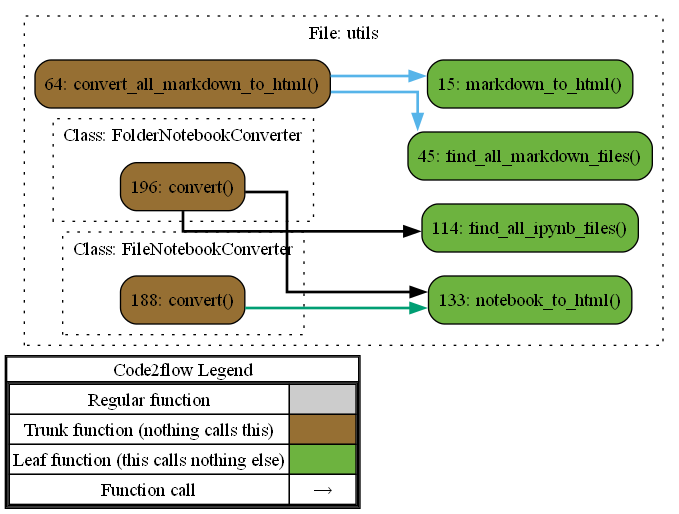